Changes to normflows (see https://github.com/nVentis/normalizing-flows)
- float precision check for discriminant: https://github.com/bayesiains/nflows/pull/71
- init_identity from: https://github.com/VincentStimper/normalizing-flows/blob/848277e2fdd306c16b48dc6814e2d7f8ddaeb2c8/normflows/flows/neural_spline/wrapper.py#L203
- added HypercubeUniform distribution with adjustable boundaries per dimension

In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.utils import module_reload
import pandas as pd

# NF example

In [2]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import normflows as nf
from normflows.distributions import BaseDistribution
from typing import Optional, Callable
import numpy as np
import pandas as pd
import torch

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
module_reload('analysis')
from analysis.nis.transforms import ScaleShift
from analysis.mc.benchmarks import camel, gaussian
from analysis.nis.plots import plot_proposal, plot_integrand, get_result
from analysis.nis.masks import binary_masks, n_couplings
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis.mc import ImportanceSamplingIntegrator

In [3]:
def train_backward(nfm, func, n_samples:int=64000, n_epochs:int=10, lr:float=5e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    q = nfm.q0.log_prob_val.exp().detach()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(q*prob)) * results**2).sum()
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        else:
            print('Skipping epoch')
            
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [16]:
def get_nfm(q0:BaseDistribution,
            K:Optional[int]=None,
            input_size:int=2,
            hidden_units: int=256,
            hidden_layers:int=2,
            cuda_if_available:bool = True,
            flow:Callable = nf.flows.CoupledRationalQuadraticSpline,#nf.flows.AutoregressiveRationalQuadraticSpline,
            random_permute:bool=False,
            
            # Rational Spline Coupling options
            num_bins:int=16,
            tails:Optional[str]='linear',
            tail_bound:float=10.,
            init_identity:bool=True,
            seed:Optional[int]=None):
    
    if K is None:
        K = n_couplings(input_size)
        
    # Ensure couplings allow information flow through feature dimensions
    masks = binary_masks(input_size)

    if seed is not None:
        torch.manual_seed(seed)
        
    flow_args = { 'num_bins': num_bins, 'tails': tails, 'tail_bound': tail_bound, 'init_identity': init_identity }
    device = 'cpu'# torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')

    flows = []
    for i in range(K):
        flows += [flow(input_size, hidden_layers, hidden_units, reverse_mask=not (not 1 % 2), feature_mask=torch.tensor(masks[i], dtype=int), **flow_args, )]
        if random_permute:
            flows += [nf.flows.Permute(input_size)]

    # Set base distribuiton
    if isinstance(q0, HyperUniform):
        scale = (q0.high - q0.low)/(2*tail_bound)
        shift = (q0.high + q0.low)/2
        
        flows += [ScaleShift(scale=scale, shift=shift)]
        q0 = nf.distributions.base.Uniform(input_size, low=-tail_bound, high=tail_bound)
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)

    print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
    print(f"Model with {sum(p.numel() for p in nfm.parameters())} parameters")
    
    # Move model on GPU if available
    return nfm.to(device)

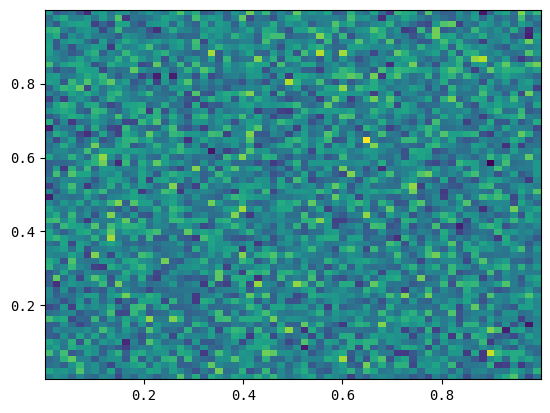

In [17]:
B = 1.
ndims = 8

a = HyperUniform(low=[0] * ndims, high=[1] * ndims)
#a = nf.distributions.base.Uniform(3, low=-B, high=B)
#a = nf.distributions.base.DiagGaussian(2, trainable=False)

z = a.sample(100000)

pX = z.T[0].detach().cpu().numpy()
pY = z.T[1].detach().cpu().numpy()

plt.hist2d(pX, pY, bins=(64,64));

In [18]:
def func(args):
    lib = torch if isinstance(args, torch.Tensor) else np
    return lib.exp(-5*lib.sqrt(args.T[0]**2 + args.T[1]**2 +args.T[2]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)
    
    # old center: new_width/2
    # new center: (max+min)/2

In [10]:
func = camel

In [42]:
from analysis.mc import ImportanceSamplingIntegrator
from analysis.nis.distributions import HyperUniform
from math import ceil, log2

class NeuralImportanceSamplingIntegrator(ImportanceSamplingIntegrator):
    def __init__(self,
                 integrand:Callable,
                 boundaries:list[list[float]],
                 hidden_units: int=256,
                 hidden_layers:int=2,

                 # Rational Spline Coupling options
                 num_bins:int=16,
                 tail_bound:float=10.,
                 init_identity:bool=True,
                 seed:Optional[int]=42,
                 cuda_if_available:bool=True,
                 num_couplings:Optional[int]=None,
                 random_permute:bool=False,
                 *args, **kwargs):
        
        super().__init__(integrand=integrand, boundaries=boundaries)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')
        
        boundaries = np.array(self.boundaries)
        input_size = len(boundaries.T)

        if num_couplings is None:
            num_couplings = n_couplings(input_size)
            
        # Ensure couplings allow information flow through feature dimensions
        masks = binary_masks(input_size)

        if seed is not None:
            torch.manual_seed(seed)
            
        flow_args = { 'num_bins': num_bins, 'tails': 'linear', 'tail_bound': tail_bound, 'init_identity': init_identity }
        flows = []
        for i in range(num_couplings):
            flows += [nf.flows.CoupledRationalQuadraticSpline(input_size, hidden_layers, hidden_units, reverse_mask=not (not 1 % 2), feature_mask=torch.tensor(masks[i], dtype=torch.int32), **flow_args, )]
            if random_permute:
                flows += [nf.flows.Permute(input_size)]

        # Set base distribuiton
        scale = (boundaries[1] - boundaries[0])/(2*tail_bound)
        shift = (boundaries[1] + boundaries[0])/2
        
        flows += [ScaleShift(scale=scale, shift=shift)]
            
        # Construct flow model
        self.q0 = nf.distributions.base.Uniform(input_size, low=-tail_bound, high=tail_bound)
        self.nfm = nf.NormalizingFlow(q0=self.q0, flows=flows).to(self.device)
    
    def print_model_summary(self):
        print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
        print(f"Model with {sum(p.numel() for p in self.nfm.parameters())} parameters")
        
        #print(
        #    'Model: %s\nParameters: %i' %
        #    (self.nfm, sum(p.numel() for p in self.nfm.parameters()))
        #)
    

In [43]:
ndims = 8
boundaries = [ [0]*ndims, [1]*ndims ]
b = NeuralImportanceSamplingIntegrator(integrand=camel, boundaries=boundaries)
b.print_model_summary()

CPU
Model with 1877712 parameters


In [44]:
b.q0.sample(10)

tensor([[-6.5653, -4.6032,  1.4006, -5.1196,  7.6728, -9.7581, -9.1591,  7.1863],
        [-8.2579, -4.2890, -2.0124, -4.2270, -3.7887, -4.6617,  6.1644,  3.6173],
        [ 2.2227, -3.5288,  0.6005, -6.1738,  7.6921, -2.3417, -9.2603, -3.6852],
        [ 4.7033, -0.0803,  2.8264,  1.2719, -7.6412, -7.7193,  7.4796, -7.3432],
        [ 4.4981, -5.1617, -6.9192,  1.3881, -1.0023, -0.4426,  9.8450,  0.6106],
        [-8.6835, -6.2034, -0.5415, -3.0797, -6.1935,  1.5657,  0.1464,  1.8619],
        [-2.0525,  1.1849, -7.6127, -2.6583, -8.0716,  0.1582,  3.6188,  0.7263],
        [-4.6677, -7.5414,  8.6316,  3.0372, -2.2700,  0.7353,  5.2114, -1.1297],
        [ 9.3621, -6.0784, -5.8711,  7.3330,  4.2673, -2.7740,  6.5421, -5.0083],
        [-6.8959,  7.0512,  1.1378,  2.1883,  1.0148,  8.2038, -1.6242,  0.9187]])

In [46]:
#nfm = get_nfm(q0=a, hidden_units=32, hidden_layers=5, num_bins=16, input_size=8, tails='linear', tail_bound=B)
#context = {}

plot_proposal(b.nfm, n_samples=8192)
plot_proposal(b.q0, n_samples=8192)

print(f'NF @ Identity : {get_result(b.nfm, func, n_samples=32000)}')
print(f'Uniform dist  : {get_result(b.q0, func, n_samples=32000)}')

# samples, log_p = nfm.sample(1000)
# results = func(samples).detach().cpu().numpy()

# plot_integrand(nfm, func, n_samples=4096)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [42]:
def kl_div(true:torch.Tensor, test:torch.Tensor, logp:torch.Tensor, logq:torch.Tensor):
    true = true.detach()
    test = test.detach()
    logp = logp.detach()
    
    return (true/test*( logp - logq )).mean()

def exp_div(true:torch.Tensor, test:torch.Tensor, logp:torch.Tensor, logq:torch.Tensor):
    true = true.detach()
    test = test.detach()
    logp = logp.detach()
    
    return (true/test*( logp - logq )**2).mean()

def chi2_div(true:torch.Tensor, test:torch.Tensor, logp:torch.Tensor, logq:torch.Tensor):
    del logp, logq
    
    return ((true.detach() - test)**2 / test / test.detach()).mean()

In [43]:
def train_iflow(nfm, func:Callable, loss_func:Callable=kl_div,
                n_samples:int=64000, n_epochs:int=10, lr:float=5e-4,
                lr_decay_factor:float=0.9, context=context):
    
    if not 'optimizer' in context:
        context['optimizer'] = torch.optim.Adam(nfm.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_factor, last_epoch=-1)
    
    for i in range(n_epochs):
        context['optimizer'].zero_grad()
        
        samples, logq = nfm.sample(n_samples)
        true = torch.abs(func(samples)).detach()
        
        #with torch.no_grad():
        test = logq.exp()
        mean, var = torch.mean(true/test).detach(), torch.var(true/test).detach()
        
        true = true/mean
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16)            
        
        loss = loss_func(true, test, logp, logq)
        
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            context['optimizer'].step()
            #scheduler.step()
        else:
            print('Skipping loss')
        #loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        #loss = (1/n_samples) * var
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}") #| Last LR {scheduler.get_last_lr()}")

In [39]:
n_samples = 16000
#train_backward(nfm, func, n_epochs=20, n_samples=n_samples, lr=2e-4)
train_iflow(nfm, func, loss_func=exp_div, n_epochs=10, n_samples=n_samples, lr=1e-3, context=context)

Epoch 0: 6.2647576332092285 | Var 666.7169799804688
Epoch 1: 5.0625505447387695 | Var 13.407058715820312
Epoch 2: 5.059944152832031 | Var 2.349846601486206
Epoch 3: 5.957945823669434 | Var 2.4620614051818848
Epoch 4: 6.130379676818848 | Var 0.2831965684890747
Epoch 5: 7.112651348114014 | Var 0.1453842669725418
Epoch 6: 8.063054084777832 | Var 0.09338533878326416
Epoch 7: 9.13075065612793 | Var 0.053454454988241196
Epoch 8: 6.188966751098633 | Var 3.6143096622254234e-06
Epoch 9: 8.07107925415039 | Var 6.264872354222462e-05


NF          : (5.799052814836614e-05, 8.44038549985271e-06)
Uniform dist: (0.9110177755355835, 97.79975128173828)
Using inferred bounds 8.821487426757812e-06 to 0.9999701380729675


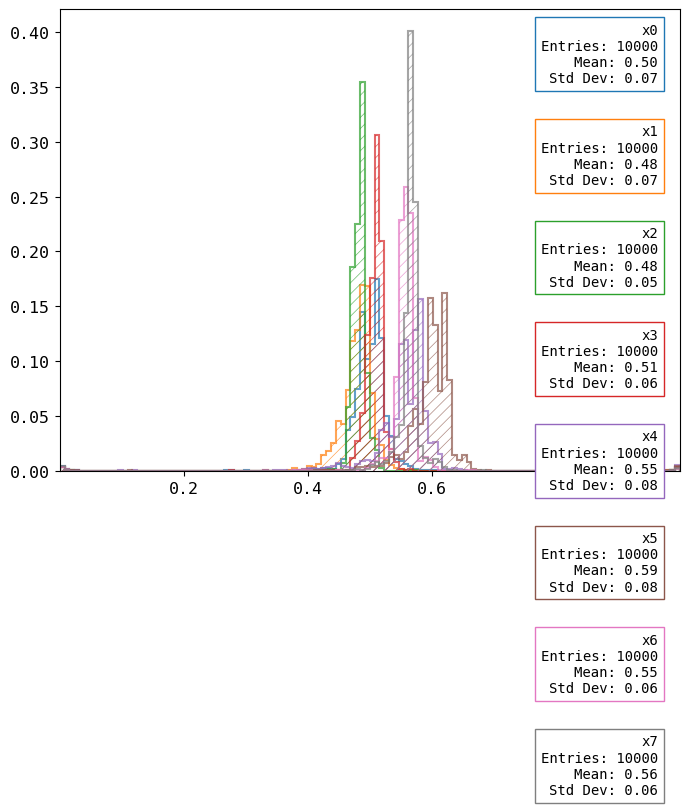

In [40]:
n_samples = 10000

print(f'NF          : {get_result(nfm, func, n_samples=n_samples)}')
print(f'Uniform dist: {get_result(a, func, n_samples=n_samples)}')

plot_proposal(nfm, n_samples=n_samples)

Using inferred bounds 1.0967254638671875e-05 to 0.9999980926513672


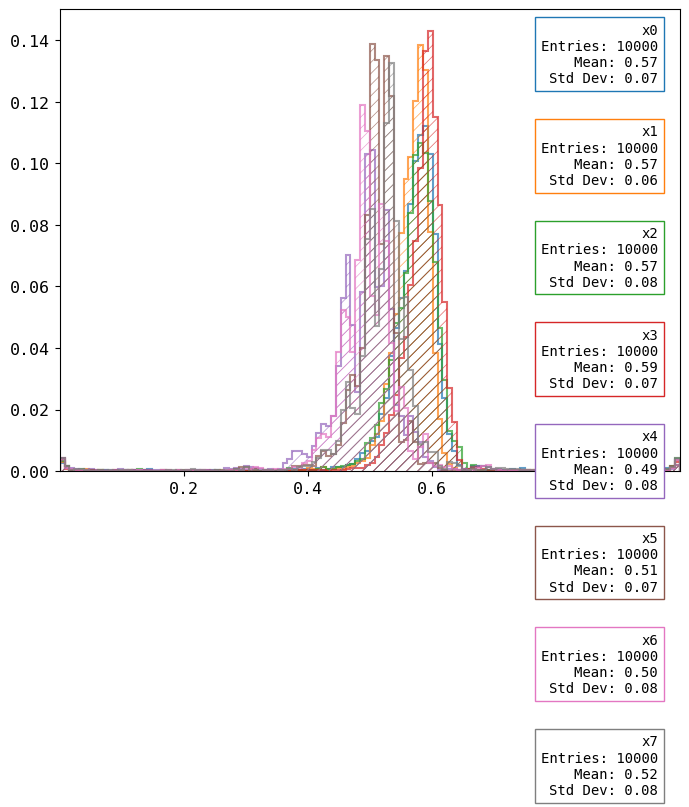

In [20]:
n_samples = 10000
plot_proposal(nfm, n_samples=n_samples)

In [242]:
print(f'NF @ Identity : {get_result(nfm, func, n_samples=32000)}')
print(f'Uniform dist  : {get_result(a, func, n_samples=32000)}')

NF @ Identity : (2.380526140311608e-26, 0.0)
Uniform dist  : (0.9595483541488647, 145.56045532226562)


In [97]:
def normalized(func, dist, n_samples:int=32000):
    integral, var = get_result(dist, func, n_samples=n_samples)
    return lambda args: func(args)/integral

(8.045150725074194, 2.422713075643302e-07)


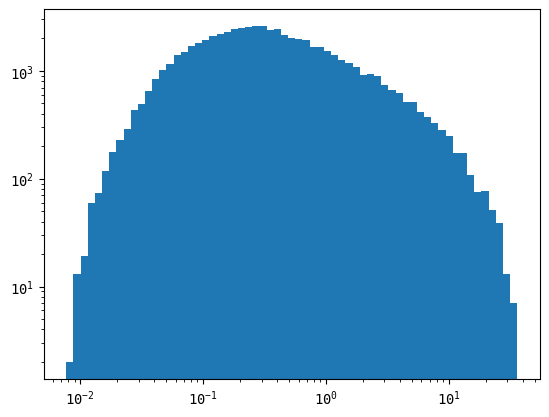

In [98]:
import scipy.integrate as integrate
func_n = normalized(func, a, 64000)

res = func_n(a.sample(64000))
#r = (samples.T[0]**2 + samples.T[1]**2 + samples.T[2]**2 ).sqrt()

logbins = np.geomspace(res.min(), res.max(), 64)
plt.hist(res, bins=logbins)
plt.xscale('log')
plt.yscale('log')

print(integrate.tplquad(lambda x,y,z: func_n(np.array([x,y,z])), -1, 1, -1, 1, -1, 1))

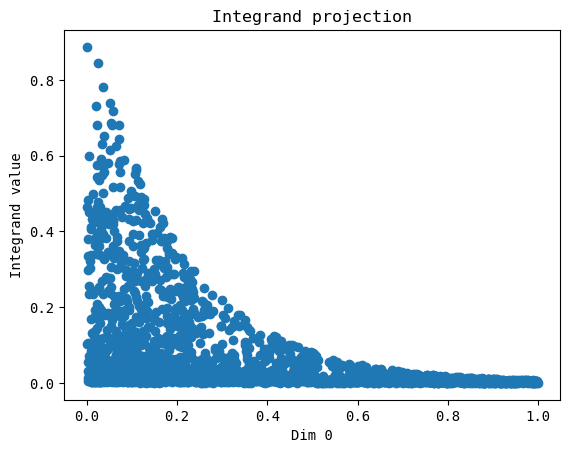

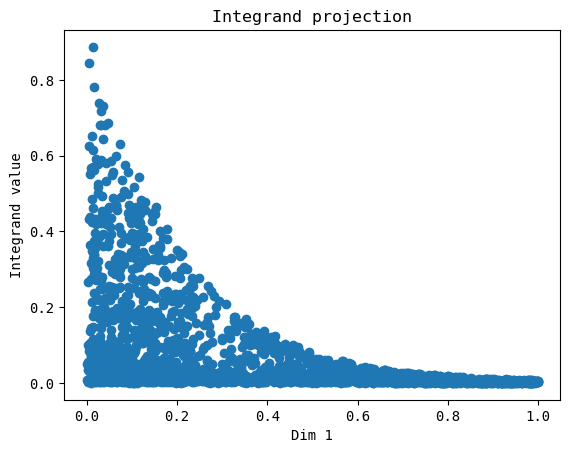

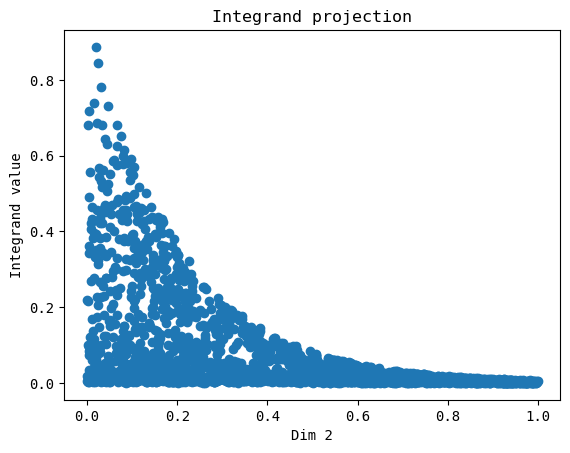

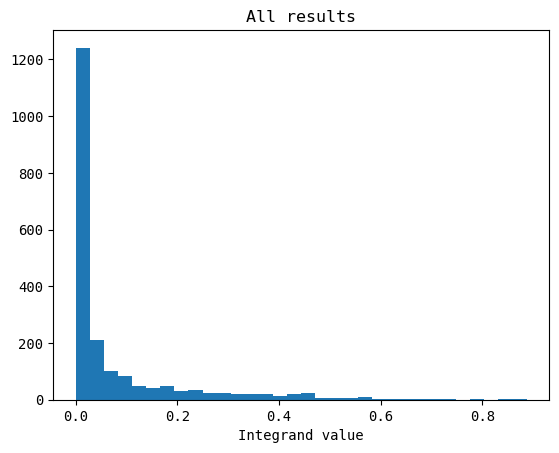

In [99]:
plot_integrand(nfm, func, y_log=False)

In [100]:
n_samples=4096
get_result(nfm, func, n_samples=n_samples)

(0.18802474439144135, 0.0030744464602321386)

In [101]:
with torch.no_grad():
    samples, logq = nfm.sample(n_samples)
    true = torch.abs(func(samples))
    test = logq.exp()
    mean = torch.mean(true/test).item()
    var = torch.var(true/test)

    print(mean, torch.sqrt(var/(n_samples-1.)).item())

0.18323089182376862 0.003156024729833007
